# Utilities

## Import necessary libraries

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import optimizers
from keras.layers import GaussianNoise
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
import pandas as pd
import math
from matplotlib import pyplot as plt
import os
import pickle
import random
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

## Load dataset

I uploaded the dataset to drive. So retrieving the data set from drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.listdir('drive/MyDrive/DeepLearningCSCE636')

csce636_train_images = pickle.load(open('drive/MyDrive/DeepLearningCSCE636/636_project1_train_images', 'rb'))
csce636_train_labels = pickle.load(open('drive/MyDrive/DeepLearningCSCE636/636_project1_train_labels', 'rb'))

csce636_train_images = csce636_train_images.reshape((csce636_train_images.shape[0], 28, 28, 1))
csce636_train_images = csce636_train_images.astype('float') / 255.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Create the training and test set from the given dataset using 20:80 split.

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(csce636_train_images, csce636_train_labels, test_size = 0.2, random_state=42)

In [ ]:
# renaming the variables for simplicity
X_train = train_images
y_train = train_labels
X_test = test_images
y_test = test_labels
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(48000, 28, 28, 1)
(48000,)
(12000, 28, 28, 1)
(12000,)


## Function to plot training and validation accuracy and loss

In [ ]:
import matplotlib.pyplot as plt
def plot_and_print(history, model, X_test, y_test):
    # Set the figure size for both plots
    plt.figure(figsize=(10, 10))  # Adjust the width and height as needed

    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, "bo", label="Training accuracy")
    plt.plot(epochs, val_acc, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

    # Evaluation on the test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {test_acc:.3f}")

## Define callback functions

In [ ]:
# using variable learning rate for all models
variable_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = 5) #, min_lr = 0.0000001)

# using early stopping if validation loss does not improve after 10 epochs
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# using checpointing to save the best trained weights
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = 'csce636_project_1.x',
    save_best_only = True,
    monitor = 'val_loss')

## Function to create and train model: common code for multiple models

In [ ]:
def create_and_train_model(inputs, x, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    # define output layer
    outputs = layers.Dense(10, activation="softmax")(x)
    # define model
    model = keras.Model(inputs=inputs, outputs=outputs)
    # compile model
    model.compile(optimizer = optimizers.RMSprop(),
      loss="sparse_categorical_crossentropy",
      metrics=["accuracy"])
    # train model using cross validation split of 20% for 100 epochs
    history = model.fit(X_train,
                        y_train,
                        epochs=100,
                        validation_split = 0.2,
                        callbacks=[early_stopping, variable_learning_rate, model_checkpoint],
                        batch_size=256,
                        verbose=False)
    plot_and_print(history, model, X_test, y_test)
    return model

## Define input layer

In [ ]:
# defining inputs (common for model)
inputs = keras.Input(shape=(28, 28, 1))

# Creating different models

## Set 1 : Use multiple convolutional, maxpooling and dropout layers

#### Keep same padding for all layers. Keep filter size from 4 to 512 in convolutional layers.
**Gives 11% accuracy**

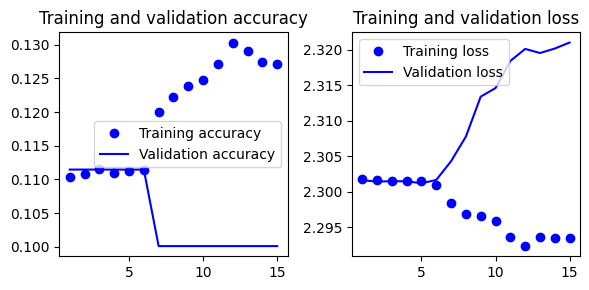

375/375 [==============================] - 1s 3ms/step - loss: 2.3013 - accuracy: 0.1117
Test accuracy: 0.112


In [ ]:
# create layers for the model
x = layers.Conv2D(filters=4, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=8, kernel_size=3, activation="relu", padding='same')(x)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu", padding='same')(x)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same')(x)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same')(x)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu", padding='same')(x)
x = layers.Flatten()(x)

# create and train model
model = create_and_train_model(inputs, x)

#### Keep same padding for all layers. Keep filter size from 16 to 512 in convolutional layers.
**Gives 11% accuracy**

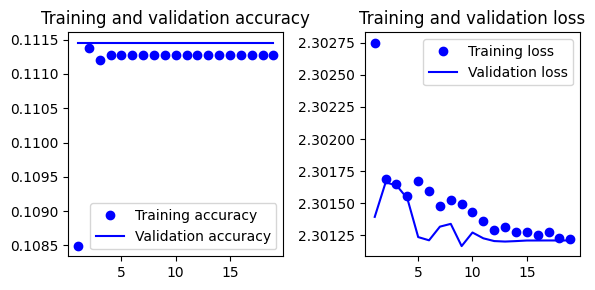

375/375 [==============================] - 2s 4ms/step - loss: 2.3013 - accuracy: 0.1117
Test accuracy: 0.112


In [ ]:
# create layers for the model
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu", padding='same')(inputs)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same')(x)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same')(x)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu", padding='same')(x)
x = layers.Flatten()(x)

# create and train model
model = create_and_train_model(inputs, x)

#### Remove padding for convolutional layers. Keep filter size from 32 to 128 in convolutional layers. Reduce number of layers.
**Gives 66.6% accuracy**

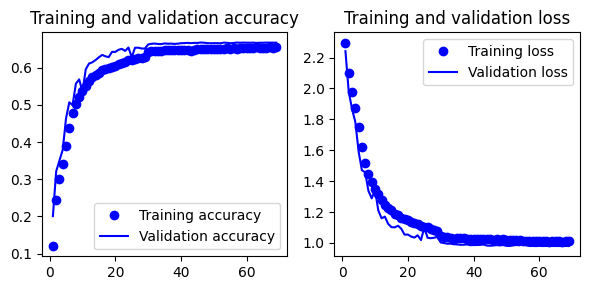

375/375 [==============================] - 1s 3ms/step - loss: 0.9828 - accuracy: 0.6659
Test accuracy: 0.666


In [ ]:
# create layers for the model
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

# create and train model
model = create_and_train_model(inputs, x)

#### Try fine tuning
* Remove padding for convolutional layers
* Keep filter size from 32 to 128 in convolutional layers
* Change dropout percentage
* Add regularization

**Gives 62.8% accuracy**


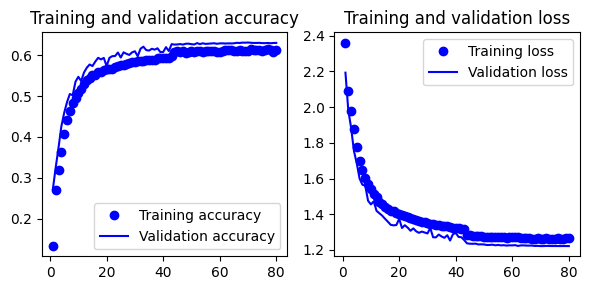

375/375 [==============================] - 1s 4ms/step - loss: 1.2242 - accuracy: 0.6285
Test accuracy: 0.628


In [ ]:
# create layers for the model
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", kernel_regularizer=l2(0.001))(inputs)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=l2(0.001))(x)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", kernel_regularizer=l2(0.001))(x)
x = layers.Flatten()(x)

# create and train model
model = create_and_train_model(inputs, x)

## Set 2: Use convolutional, maxpooling, dense and dropout layers.

#### Remove padding for convolutional layers. Keep filter size from 32 to 128 in convolutional layers. Add a dense layer.
**Gives 66.3% accuracy**

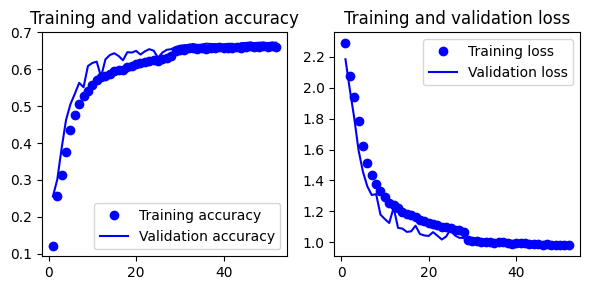

375/375 [==============================] - 1s 4ms/step - loss: 0.9828 - accuracy: 0.6633
Test accuracy: 0.663


In [ ]:
# create layers for the model
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(units = 128, use_bias=True)(x)
# create and train model
model = create_and_train_model(inputs, x)

#### Remove padding for convolutional layers. Keep filter size from 16 to 64 in convolutional layers. Add a dense layer
**Gives 62.8% accuracy**

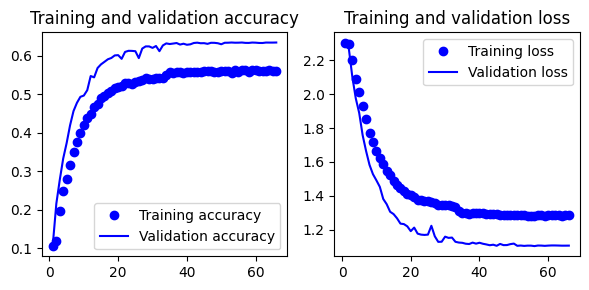

375/375 [==============================] - 1s 3ms/step - loss: 1.1083 - accuracy: 0.6283
Test accuracy: 0.628


In [ ]:
# create layers for the model
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
x = layers.Dense(units = 128, use_bias=True)(x)
# create and train model
model = create_and_train_model(inputs, x)

#### Remove padding for convolutional layers. Keep filter size from 16 to 64 in convolutional layers. Add 2 dense layers
**Gives 65.9% accuracy**

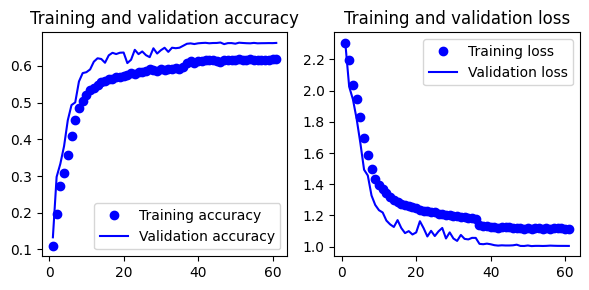

375/375 [==============================] - 1s 3ms/step - loss: 1.0090 - accuracy: 0.6590
Test accuracy: 0.659


In [ ]:
# create layers for the model
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
x = layers.Dense(units = 64, use_bias=True)(x)
x = layers.Dense(units = 32, use_bias=True)(x)
# create and train model
model = create_and_train_model(inputs, x)

#### Increase size of dense layer = 256
**Gives 66.5% accuracy**

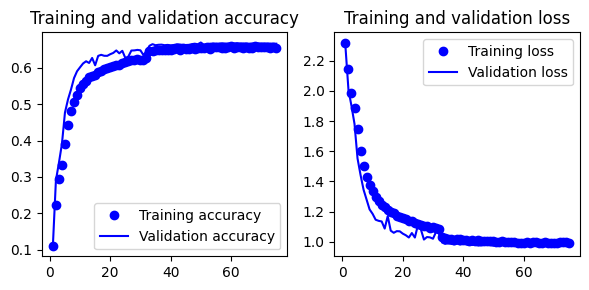

375/375 [==============================] - 1s 3ms/step - loss: 0.9823 - accuracy: 0.6648
Test accuracy: 0.665


In [ ]:
# create layers for the model
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(units = 256, use_bias=True)(x)
# create and train model
model = create_and_train_model(inputs, x)

## Set 3: Inspiration from [this](https://towardsdatascience.com/going-beyond-99-mnist-handwritten-digits-recognition-cfff96337392) article.

#### Keeping model as it is in the article
**Gives 65.9% accuracy**

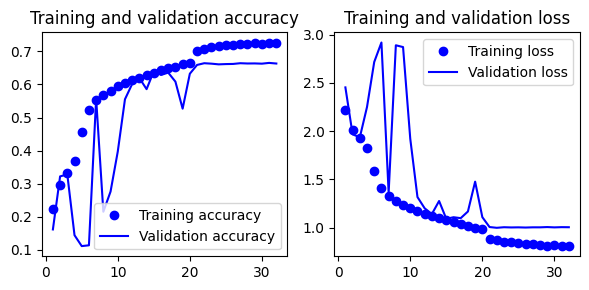

375/375 [==============================] - 2s 5ms/step - loss: 1.0178 - accuracy: 0.6588
Test accuracy: 0.659


In [ ]:
x = layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (32,32,1), kernel_regularizer=l2(0.0005))(inputs)
x = layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size = 2, strides = 2)(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', kernel_regularizer=l2(0.0005))(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size = 2, strides = 2)(x)
x = layers.Dropout(0.25)(x)
x = layers.Flatten()(x)
x = layers.Dense(units = 256, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(units = 128, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(units = 84, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.25)(x)
model = create_and_train_model(inputs, x)


#### Adding Preprocessing Step

In [ ]:
new_X_train = np.array(X_train)
new_X_test = np.array(X_test)

# Padding the images by 2 pixels since in the paper input images were 32x32
new_X_train = np.pad(new_X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
new_X_test = np.pad(new_X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')

# Standardization
mean_px = new_X_train.mean().astype(np.float32)
std_px = new_X_train.std().astype(np.float32)
new_X_train = (new_X_train - mean_px)/(std_px)

mean_px = new_X_test.mean().astype(np.float32)
std_px = new_X_test.std().astype(np.float32)
new_X_test = (new_X_test - mean_px)/(std_px)

# One-hot encoding the labels
new_y_train = to_categorical(y_train, num_classes = 10)
new_y_test = to_categorical(y_test, num_classes = 10)


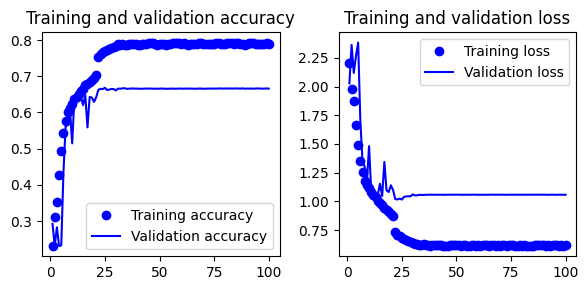

375/375 [==============================] - 1s 3ms/step - loss: 1.0793 - accuracy: 0.6591
Test accuracy: 0.659


In [ ]:
new_inputs = keras.Input(shape=(32, 32, 1))
x = layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (32,32,1), kernel_regularizer=l2(0.0005))(new_inputs)
x = layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size = 2, strides = 2)(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', kernel_regularizer=l2(0.0005))(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size = 2, strides = 2)(x)
x = layers.Dropout(0.25)(x)
x = layers.Flatten()(x)
x = layers.Dense(units = 256, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(units = 128, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(units = 84, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.25)(x)
# model = create_and_train_model(new_inputs, x, new_X_train, new_y_train, new_X_test, new_y_test)
# define output layer
new_outputs = layers.Dense(10, activation="softmax")(x)
# define model
model1 = keras.Model(inputs=new_inputs, outputs=new_outputs)
# compile model
model1.compile(optimizer = optimizers.RMSprop(),
  loss="categorical_crossentropy",
  metrics=["accuracy"])
# train model using validation split of 20% for 100 epochs
history1 = model1.fit(new_X_train,
                    new_y_train,
                    epochs=100,
                    validation_split = 0.2,
                    # callbacks=[early_stopping, variable_learning_rate, model_checkpoint],
                    callbacks=[variable_learning_rate, model_checkpoint],
                    batch_size=256,
                    verbose=False)
plot_and_print(history1, model1, new_X_test, new_y_test)



#### Updating layers and parameter
**Gives 69.3% accuracy**

Epoch 1/100
600/600 [==============================] - 15s 12ms/step - loss: 2.4091 - accuracy: 0.1627 - val_loss: 2.0250 - val_accuracy: 0.2903 - lr: 0.0010
Epoch 2/100
600/600 [==============================] - 6s 10ms/step - loss: 2.0894 - accuracy: 0.2679 - val_loss: 1.9971 - val_accuracy: 0.3013 - lr: 0.0010
Epoch 3/100
600/600 [==============================] - 5s 9ms/step - loss: 2.0229 - accuracy: 0.2982 - val_loss: 1.9143 - val_accuracy: 0.3397 - lr: 0.0010
Epoch 4/100
600/600 [==============================] - 5s 9ms/step - loss: 1.8733 - accuracy: 0.3615 - val_loss: 2.0226 - val_accuracy: 0.2974 - lr: 0.0010
Epoch 5/100
600/600 [==============================] - 6s 10ms/step - loss: 1.6006 - accuracy: 0.4678 - val_loss: 1.3449 - val_accuracy: 0.5616 - lr: 0.0010
Epoch 6/100
600/600 [==============================] - 5s 9ms/step - loss: 1.4505 - accuracy: 0.5214 - val_loss: 1.1936 - val_accuracy: 0.6058 - lr: 0.0010
Epoch 7/100
600/600 [==============================] - 6s 10

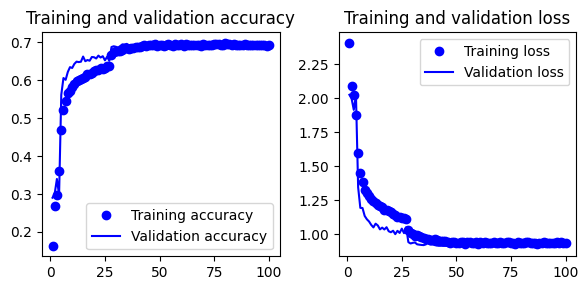

375/375 [==============================] - 4s 8ms/step - loss: 0.9381 - accuracy: 0.6927
Test accuracy: 0.693


In [ ]:
new_inputs = keras.Input(shape=(32, 32, 1))
x = layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (32,32,1), kernel_regularizer=l2(0.0005))(new_inputs)
x = layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size = 2, strides = 2)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', kernel_regularizer=l2(0.0005))(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size = 2, strides = 2)(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
x = layers.Dense(units = 256, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(units = 128, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(units = 64, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

# define output layer
new_outputs = layers.Dense(10, activation="softmax")(x)
# define model
model1 = keras.Model(inputs=new_inputs, outputs=new_outputs)
# compile model
model1.compile(optimizer = optimizers.Adam(),
  loss="categorical_crossentropy",
  metrics=["accuracy"])
# train model using validation split of 20% for 100 epochs
history1 = model1.fit(new_X_train,
                    new_y_train,
                    epochs=100,
                    validation_split = 0.2,
                    # callbacks=[early_stopping, variable_learning_rate, model_checkpoint],
                    callbacks=[variable_learning_rate, model_checkpoint],
                    batch_size=64,
                    verbose=True)
plot_and_print(history1, model1, new_X_test, new_y_test)

#### Removing layers and changing regularization
**Gives 69.3% accuracy**

Epoch 1/100
600/600 [==============================] - 12s 11ms/step - loss: 2.6255 - accuracy: 0.2255 - val_loss: 2.2121 - val_accuracy: 0.3014 - lr: 0.0010
Epoch 2/100
600/600 [==============================] - 7s 12ms/step - loss: 2.1718 - accuracy: 0.2930 - val_loss: 2.0206 - val_accuracy: 0.3279 - lr: 0.0010
Epoch 3/100
600/600 [==============================] - 9s 14ms/step - loss: 1.8952 - accuracy: 0.3673 - val_loss: 1.7965 - val_accuracy: 0.4709 - lr: 0.0010
Epoch 4/100
600/600 [==============================] - 6s 11ms/step - loss: 1.5596 - accuracy: 0.4855 - val_loss: 1.3200 - val_accuracy: 0.5809 - lr: 0.0010
Epoch 5/100
600/600 [==============================] - 6s 11ms/step - loss: 1.4325 - accuracy: 0.5296 - val_loss: 1.2876 - val_accuracy: 0.5769 - lr: 0.0010
Epoch 6/100
600/600 [==============================] - 6s 10ms/step - loss: 1.3807 - accuracy: 0.5471 - val_loss: 1.1891 - val_accuracy: 0.6144 - lr: 0.0010
Epoch 7/100
600/600 [==============================] - 4s

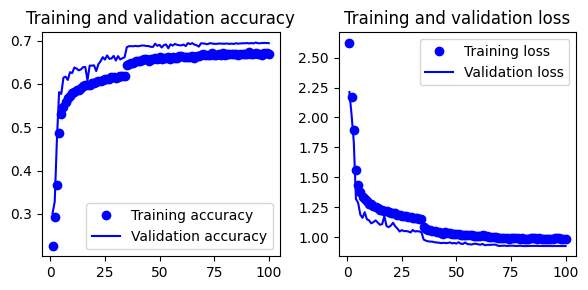

375/375 [==============================] - 2s 4ms/step - loss: 0.9348 - accuracy: 0.6928
Test accuracy: 0.693


In [ ]:
new_inputs = keras.Input(shape=(32, 32, 1))
x = layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (32,32,1), kernel_regularizer=l1_l2(0.0005, 0.0005))(new_inputs)
x = layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size = 2, strides = 2)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', kernel_regularizer=l1_l2(0.0005, 0.0005))(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size = 2, strides = 2)(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
x = layers.Dense(units = 256, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

# define output layer
new_outputs = layers.Dense(10, activation="softmax")(x)
# define model
model1 = keras.Model(inputs=new_inputs, outputs=new_outputs)
# compile model
model1.compile(optimizer = optimizers.Adam(),
  loss="categorical_crossentropy",
  metrics=["accuracy"])
# train model using validation split of 20% for 100 epochs
history1 = model1.fit(new_X_train,
                    new_y_train,
                    epochs=100,
                    validation_split = 0.2,
                    # callbacks=[early_stopping, variable_learning_rate, model_checkpoint],
                    callbacks=[variable_learning_rate, model_checkpoint],
                    batch_size=64,
                    verbose=True)
plot_and_print(history1, model1, new_X_test, new_y_test)



## Set 4: Inspiration from [this](https://machinelearningmastery.com/how-to-improve-deep-learning-model-robustness-by-adding-noise/) article.

#### Add Gaussian Noise as layers.
**Gives 69.3% accuracy**

Epoch 1/100
600/600 [==============================] - 18s 14ms/step - loss: 2.3568 - accuracy: 0.1831 - val_loss: 2.0030 - val_accuracy: 0.2943 - lr: 0.0010
Epoch 2/100
600/600 [==============================] - 10s 16ms/step - loss: 2.0759 - accuracy: 0.2748 - val_loss: 1.9978 - val_accuracy: 0.2974 - lr: 0.0010
Epoch 3/100
600/600 [==============================] - 9s 15ms/step - loss: 2.0016 - accuracy: 0.3064 - val_loss: 1.9033 - val_accuracy: 0.3492 - lr: 0.0010
Epoch 4/100
600/600 [==============================] - 8s 13ms/step - loss: 1.7876 - accuracy: 0.3958 - val_loss: 1.5437 - val_accuracy: 0.5052 - lr: 0.0010
Epoch 5/100
600/600 [==============================] - 8s 14ms/step - loss: 1.5524 - accuracy: 0.4843 - val_loss: 1.2784 - val_accuracy: 0.5769 - lr: 0.0010
Epoch 6/100
600/600 [==============================] - 7s 11ms/step - loss: 1.4387 - accuracy: 0.5271 - val_loss: 1.1852 - val_accuracy: 0.6115 - lr: 0.0010
Epoch 7/100
600/600 [==============================] - 6

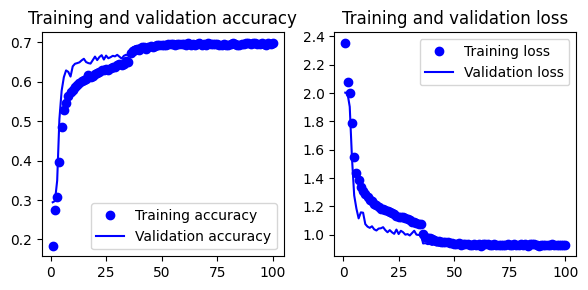

375/375 [==============================] - 3s 5ms/step - loss: 0.9445 - accuracy: 0.6931
Test accuracy: 0.693


In [ ]:
new_inputs = keras.Input(shape=(32, 32, 1))
x = layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (32,32,1), kernel_regularizer=l2(0.0005))(new_inputs)
x = layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size = 2, strides = 2)(x)
x = layers.GaussianNoise(0.1)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', kernel_regularizer=l2(0.0005))(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size = 2, strides = 2)(x)
x = layers.GaussianNoise(0.1)(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
x = layers.Dense(units = 256, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(units = 128, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(units = 64, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

# define output layer
new_outputs = layers.Dense(10, activation="softmax")(x)
# define model
model1 = keras.Model(inputs=new_inputs, outputs=new_outputs)
# compile model
model1.compile(optimizer = optimizers.Adam(),
  loss="categorical_crossentropy",
  metrics=["accuracy"])
# train model using validation split of 20% for 100 epochs
history1 = model1.fit(new_X_train,
                    new_y_train,
                    epochs=100,
                    validation_split = 0.2,
                    # callbacks=[early_stopping, variable_learning_rate, model_checkpoint],
                    callbacks=[variable_learning_rate, model_checkpoint],
                    batch_size=64,
                    verbose=True)
plot_and_print(history1, model1, new_X_test, new_y_test)

## Set 5: Removing noise using KNN (inspiration from [this](https://medium.com/nerd-for-tech/recovering-the-original-image-from-the-image-having-noise-using-knn-mnist-handwritten-digit-530edf39587e) article). - **DOES NOT WORK**.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# reshape dataset
knn_X_train = X_train.reshape(-1, 784) # .reshape()
knn_X_test = X_test.reshape(-1, 784) # .reshape()
knn_y_train = y_train.reshape(-1) # .reshape()
knn_y_test = y_test.reshape(-1) # .reshape()

knn_clf = KNeighborsClassifier()
knn_clf.fit(np.asarray(knn_X_train), knn_y_train)
predicted_labels = knn_clf.predict(np.asarray(knn_X_test))

KNeighborsClassifier()

In [ ]:
# Create an array to store the reconstructed clean images
reconstructed_images = np.zeros_like(knn_X_test)

# Loop through the noisy test images and select the corresponding clean images
for i in range(len(knn_X_test)):
    label = predicted_labels[i]
    clean_image = knn_X_train[knn_y_train == label][0]  # Assuming the first occurrence of the label is the clean image
    reconstructed_images[i] = clean_image

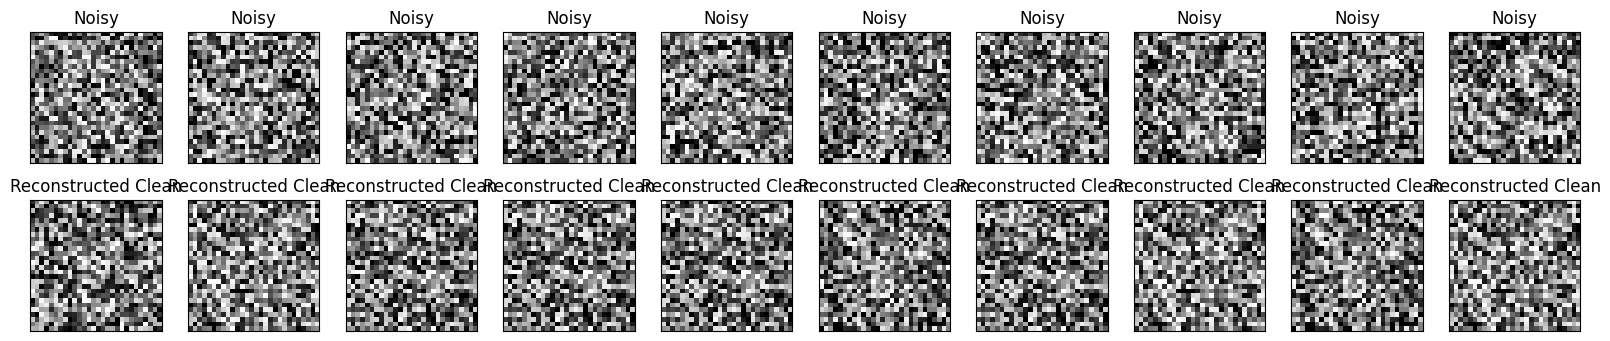

In [ ]:
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display noisy image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(knn_X_test[i].reshape(28, 28), cmap='gray')
    plt.title('Noisy')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed clean image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    plt.title('Reconstructed Clean')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Set 6: Training with clean MNIST dataset together.
**Gives 9.9% accuracy**

In [ ]:
# Load training images and labels for your CSCE636 project
csce636_train_images = pickle.load(open('drive/MyDrive/DeepLearningCSCE636/636_project1_train_images', 'rb'))
csce636_train_labels = pickle load(open('drive/MyDrive/DeepLearningCSCE636/636_project1_train_labels', 'rb'))

# Normalize the pixel values of the images to a range between 0 and 1
csce636_train_images = csce636_train_images.astype('float') / 255.

# Reshape the images to the required format (assuming a 28x28 size with 1 channel)
csce636_train_images = csce636_train_images.reshape((csce636_train_images.shape[0], 28, 28, 1))

# Split the CSCE636 training data into training and testing sets
csce636_X_train, csce636_X_test, csce636_y_train, csce636_y_test = train_test_split(csce636_train_images, csce636_train_labels, test_size=0.2, random_state=12)

# Load the MNIST dataset
(mnist_X_train, mnist_y_train), (mnist_X_test, mnist_y_test) = mnist.load_data()

# Normalize the pixel values of the MNIST images to a range between 0 and 1
mnist_X_train = mnist_X_train.astype('float') / 255.
mnist_X_test = mnist_X_test.astype('float') / 255.

# Reshape the MNIST images to the required format
mnist_X_train = np.reshape(mnist_X_train, (60000, 28, 28, 1))
mnist_X_test = np.reshape(mnist_X_test, (10000, 28, 28, 1))

# Combine the CSCE636 and MNIST training data
combined_X_train = np.vstack((csce636_X_train, mnist_X_train))
combined_y_train = np.hstack((csce636_y_train, mnist_y_train))

# Shuffle the combined dataset
combined_X_train, combined_y_train = shuffle(combined_X_train, combined_y_train, random_state=42)

# Create a new array for the combined dataset
c_new_X_train = np.array(combined_X_train)
c_new_X_test = np.array(csce636_X_test)

# Pad the images with 2 pixels on all sides to make them 32x32 as mentioned in the paper
c_new_X_train = np.pad(c_new_X_train, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')
c_new_X_test = np.pad(c_new_X_test, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')

# Standardize the pixel values of the images
mean_px = new_X_train.mean().astype(np.float32)
std_px = new_X_train.std().astype(np.float32)
c_new_X_train = (c_new_X_train - mean_px) / (std_px)

mean_px = new_X_test.mean().astype(np.float32)
std_px = new_X_test.std().astype(np.float32)
c_new_X_test = (c_new_X_test - mean_px) / (std_px)

# One-hot encode the labels for the combined dataset and the CSCE636 test set
c_new_y_train = to_categorical(combined_y_train, num_classes=10)
c_new_y_test = to_categorical(csce636_y_test, num_classes=10)


Epoch 1/100
1350/1350 [==============================] - 24s 13ms/step - loss: 1.2357 - accuracy: 0.5831 - val_loss: 0.9743 - val_accuracy: 0.6784 - lr: 0.0010
Epoch 2/100
1350/1350 [==============================] - 17s 13ms/step - loss: 1.0263 - accuracy: 0.6517 - val_loss: 0.9122 - val_accuracy: 0.6880 - lr: 0.0010
Epoch 3/100
1350/1350 [==============================] - 18s 13ms/step - loss: 0.8968 - accuracy: 0.7039 - val_loss: 0.6693 - val_accuracy: 0.7822 - lr: 0.0010
Epoch 4/100
1350/1350 [==============================] - 17s 13ms/step - loss: 0.7807 - accuracy: 0.7508 - val_loss: 0.6497 - val_accuracy: 0.7856 - lr: 0.0010
Epoch 5/100
1350/1350 [==============================] - 16s 11ms/step - loss: 0.7405 - accuracy: 0.7658 - val_loss: 0.6097 - val_accuracy: 0.8009 - lr: 0.0010
Epoch 6/100
1350/1350 [==============================] - 13s 10ms/step - loss: 0.7170 - accuracy: 0.7735 - val_loss: 0.6509 - val_accuracy: 0.7881 - lr: 0.0010
Epoch 7/100
1350/1350 [=================

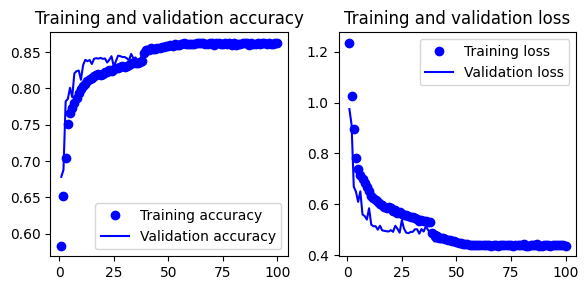

375/375 [==============================] - 1s 4ms/step - loss: 2.7724 - accuracy: 0.0989
Test accuracy: 0.099


In [ ]:
# define input layer
c_new_inputs = keras.Input(shape=(32, 32, 1))

# add layers to model
x = layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (32,32,1), kernel_regularizer=l2(0.0005))(c_new_inputs)
x = layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size = 2, strides = 2)(x)
x = layers.GaussianNoise(0.1)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', kernel_regularizer=l2(0.0005))(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size = 2, strides = 2)(x)
x = layers.GaussianNoise(0.1)(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
x = layers.Dense(units = 256, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(units = 128, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(units = 64, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

# define output layer
c_new_outputs = layers.Dense(10, activation="softmax")(x)
# define model
model2 = keras.Model(inputs=c_new_inputs, outputs=c_new_outputs)
# compile model
model2.compile(optimizer = optimizers.Adam(),
  loss="categorical_crossentropy",
  metrics=["accuracy"])
# train model using validation split of 20% for 100 epochs
history2 = model2.fit(c_new_X_train,
                    c_new_y_train,
                    epochs=100,
                    validation_split = 0.2,
                    callbacks=[variable_learning_rate, model_checkpoint],
                    batch_size=64,
                    verbose=True)
plot_and_print(history2, model1, c_new_X_test, c_new_y_test)

# Final Model

After all different experiments and results obtained, I have decided to consider the following as my final model.


*   Preprocessing:
    1. Reshape each image
    2. Convert to float and normalize
    3. Convert to numpy array
    4. Add padding to make 32x32 size
    5. Standardize each pixel using mean and standard deviation
    6. One hot encoding for labels (10 classes)


*   Deep Learning Model:
1. Convolutional layer with 32 filters, a kernel size of 5, ReLU activation, and L2 regularization for an input shape of 32x32x1.
2. Convolutional layer with 32 filters, a kernel size of 5, and no bias terms.
3. Add batch normalization to the previous layer.
4. Apply the ReLU activation function to the output of the batch normalization.
5. Implement max-pooling with a pool size of 2x2 and a stride of 2.
6. Apply dropout regularization with a rate of 0.5.
7. Add another convolutional layer with 64 filters, a kernel size of 3, ReLU activation, and L2 regularization.
8. Create another convolutional layer with 64 filters, a kernel size of 3, and no bias terms.
9. Add batch normalization to the previous layer.
10. Apply the ReLU activation function to the output of the batch normalization.
11. Implement max-pooling with a pool size of 2x2 and a stride of 2.
12. Apply dropout regularization with a rate of 0.5.
13. Flatten the output of the previous layers.
14. Create a dense (fully connected) layer with 256 units and no bias terms.
15. Add batch normalization to the dense layer.
16. Apply the ReLU activation function to the output of the batch normalization.
17. Create another dense layer with 128 units and no bias terms.
18. Add batch normalization to the dense layer.
19. Apply the ReLU activation function to the output of the batch normalization.
20. Create a final dense layer with 64 units and no bias terms.
21. Add batch normalization to the dense layer.
22. Apply the ReLU activation function to the output of the batch normalization.
23. Apply dropout regularization with a rate of 0.5.
24. Add final output layer as a dense layer with 10 units.
* Use categorical_entropy as loss function.
* Use Adam optimizer.
* Train for 100 epochs and save best weights according validation loss values.
* Use batch size of 64 and cross validation split of 0.2.



#### Preprocessing input

In [ ]:
# Convert the datasets to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

# Pad the images with 2 pixels on all sides to make them 32x32
X_train = np.pad(X_train, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')
X_test = np.pad(X_test, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')

# Standardize the pixel values of the images
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)
X_train = (X_train - mean_px) / (std_px)

mean_px = X_test.mean().astype(np.float32)
std_px = X_test.std().astype(np.float32)
X_test = (X_test - mean_px) / (std_px)

# One-hot encode the labels for training and testing datasets
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


#### Define layers of model

Epoch 1/100
600/600 [==============================] - 23s 15ms/step - loss: 2.3713 - accuracy: 0.1768 - val_loss: 2.0575 - val_accuracy: 0.2745 - lr: 0.0010
Epoch 2/100
600/600 [==============================] - 9s 15ms/step - loss: 2.0764 - accuracy: 0.2738 - val_loss: 2.0088 - val_accuracy: 0.2979 - lr: 0.0010
Epoch 3/100
600/600 [==============================] - 8s 13ms/step - loss: 2.0072 - accuracy: 0.3059 - val_loss: 1.8817 - val_accuracy: 0.3495 - lr: 0.0010
Epoch 4/100
600/600 [==============================] - 6s 11ms/step - loss: 1.8139 - accuracy: 0.3846 - val_loss: 1.9748 - val_accuracy: 0.3298 - lr: 0.0010
Epoch 5/100
600/600 [==============================] - 9s 16ms/step - loss: 1.5433 - accuracy: 0.4902 - val_loss: 1.2994 - val_accuracy: 0.5707 - lr: 0.0010
Epoch 6/100
600/600 [==============================] - 9s 15ms/step - loss: 1.4137 - accuracy: 0.5351 - val_loss: 1.2273 - val_accuracy: 0.5895 - lr: 0.0010
Epoch 7/100
600/600 [==============================] - 8s

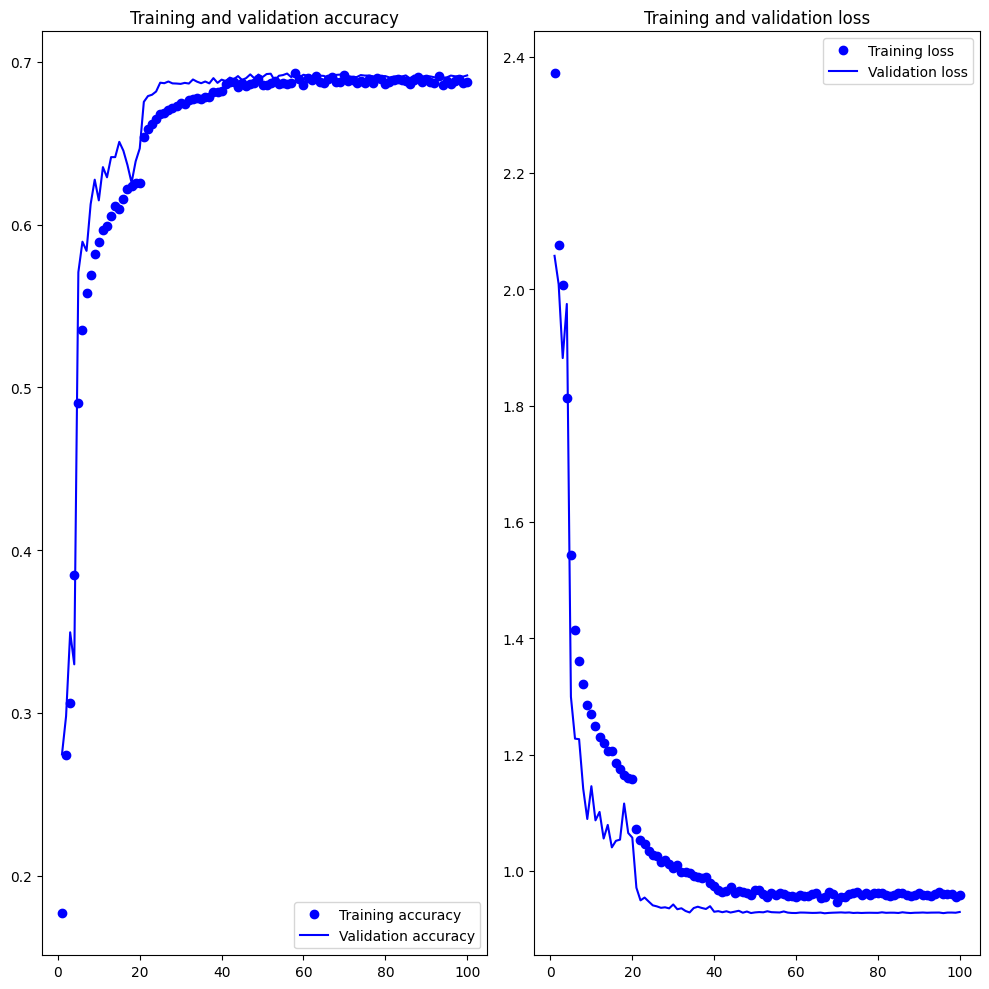

375/375 [==============================] - 2s 4ms/step - loss: 0.9108 - accuracy: 0.6957
Test accuracy: 0.696


In [ ]:
# define input layer
inputs = keras.Input(shape=(32, 32, 1))

# define and add layers to model
x = layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (32,32,1), kernel_regularizer=l2(0.0005))(inputs)
x = layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size = 2, strides = 2)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', kernel_regularizer=l2(0.0005))(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size = 2, strides = 2)(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
x = layers.Dense(units = 256, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(units = 128, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(units = 64, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

# define output layer
outputs = layers.Dense(10, activation="softmax")(x)
# define model
final_model = keras.Model(inputs=inputs, outputs=outputs)
# compile model
final_model.compile(optimizer = optimizers.Adam(),
  loss="categorical_crossentropy",
  metrics=["accuracy"])

# train model using validation split of 20% for 100 epochs
history_final = final_model.fit(X_train,
                    y_train,
                    epochs=100,
                    validation_split = 0.2,
                    callbacks=[variable_learning_rate, model_checkpoint],
                    batch_size=64,
                    verbose=True)
plot_and_print(history_final, final_model, X_test, y_test)

In [ ]:
final_model.save("jain_ayushri_csce636_project_1" + ".h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import files
files.download('jain_ayushri_csce636_project_1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Final Cell To Be Run For Grading

In [ ]:
from tensorflow.keras import models
import pickle
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import os

model = models.load_model("./jain_ayushri_csce636_project_1 (2).h5")
# test_labels = pickle.load(open("./636_project1_test_labels", 'rb'))
# test_images = pickle.load(open("./636_project1_test_images", 'rb'))

from google.colab import drive
drive.mount('/content/drive')
os.listdir('drive/MyDrive/DeepLearningCSCE636')

test_images = pickle.load(open('drive/MyDrive/DeepLearningCSCE636/636_project1_train_images', 'rb'))
test_labels = pickle.load(open('drive/MyDrive/DeepLearningCSCE636/636_project1_train_labels', 'rb'))

# test_labels = pickle.load(open("./636_project1_train_labels", 'rb'))
# test_images = pickle.load(open("./636_project1_train_images", 'rb'))

# Include your data preprocessing code if applicable
# reshape
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))
test_images = test_images.astype('float') / 255.

# add padding
test_images = np.array(test_images)
test_images = np.pad(test_images, ((0,0),(2,2),(2,2),(0,0)), 'constant')

# standardization
mean_px = test_images.mean().astype(np.float32)
std_px = test_images.std().astype(np.float32)
test_images = (test_images - mean_px)/(std_px)

# one-hot encoding the labels
test_labels = to_categorical(test_labels, num_classes = 10)
# Include your data preprocessing code if applicable

test_loss, test_acc = model.evaluate(test_images, test_labels)
your_score = round(test_acc*1000) / 10
print(f"Your Score: {your_score}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1875/1875 [==============================] - 95s 50ms/step - loss: 0.7063 - accuracy: 0.7609
Your Score: 76.1
